In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import random
from typing import Callable
import pandas as pd

In [2]:
# Configuration
DATASET_PATH = "data"
ANNOTATIONS_FILE = os.path.join(DATASET_PATH, "annotations.json")
IMAGES_DIR = os.path.join(DATASET_PATH)
INPUT_SHAPE = (384, 384)
BATCH_SIZE = 4
EPOCHS = 20
LEARNING_RATE = 1e-4
NUM_WORKERS = 0

VOC_CLASSES = [
    "background",
    "turtle_head",
    "turtle_carapace",
    "turtle_flipper",
]

VOC_COLORP = [
    [128, 0, 128],    # background - purple
    [255, 255, 0],    # head - yellow
    [0, 128, 0],      # carapace - green
    [0, 0, 255]       # flipper - blue
]

NUM_CLASSES = len(VOC_CLASSES)

# Create necessary directories
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('results', exist_ok=True)

In [3]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # If bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [4]:
class TurtleSegDataset(Dataset):
    def __init__(self, img_ids, coco, transform=None):
        super().__init__()
        self.img_ids = img_ids
        self.coco = coco
        self.transform = transform
        self.catIds = coco.getCatIds()

        print("Pre-computing masks...")
        self.masks = {}
        self.class_counts = {i: np.int64(0) for i in range(NUM_CLASSES)}

        for img_id in tqdm(img_ids, desc="Preprocessing"):
            # Get image info
            img_info = self.get_img_info_by_filename(img_id)
            # print(img_id)
            # print(img_info)

            height, width = img_info['height'], img_info['width']

            # Create an empty mask
            mask = np.zeros((height, width), dtype=np.uint8)
            mask_id = img_info['id']
            # Get all annotations for this image
            ann_ids = self.coco.getAnnIds(imgIds=mask_id, catIds=self.catIds, iscrowd=None)
            # print(ann_ids)
            # x = input()
            anns = self.coco.loadAnns(ann_ids)

            # Define category order for mask application: head > flipper > carapace
            category_order = [3, 2, 1]  # Apply head first, then flipper, then carapace

            # Apply masks in the specified order
            for cat_id in category_order:
                for ann in anns:
                    if ann['category_id'] == cat_id:
                        single_mask = self.coco.annToMask(ann)
                        # Only update pixels where the mask is currently background (0)
                        mask = np.where((single_mask == 1) & (mask == 0), cat_id, mask)

            # Save processed mask
            self.masks[img_id] = mask

            # Count pixels per class for weighting
            for class_id in range(NUM_CLASSES):
                self.class_counts[class_id] += np.sum(mask == class_id)

        # Calculate class weights based on pixel counts
        total = sum(self.class_counts.values())
        weights = {k: total / (v + 1e-8) for k, v in self.class_counts.items()}
        max_weight = max(weights.values())
        self.class_weights = {k: v / max_weight for k, v in weights.items()}
        print("Class weights:", self.class_weights)
        print("Class counts:", self.class_counts)

    def get_img_info_by_filename(self, file_name):
        # Iterate through the images in the COCO dataset to find a match by file name
        for img_info in self.coco.dataset['images']:
            if img_info['file_name'] == file_name:
                return img_info
        # If not found, raise an error
        raise ValueError(f"Image with file_name '{file_name}' not found in COCO dataset.")

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]

        # Get the specific image info using the img_id
        img_info = self.get_img_info_by_filename(img_id)

        # Load the image file using the correct file path from img_info
        image = cv2.imread(os.path.join(IMAGES_DIR, img_info['file_name']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get precomputed mask
        mask = self.masks[img_id].copy()
        
        # Resize image and mask to target shape
        image = cv2.resize(image, INPUT_SHAPE)
        mask = cv2.resize(mask, INPUT_SHAPE, interpolation=cv2.INTER_NEAREST)

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

def get_training_augmentation():
    return A.Compose([
        A.RandomResizedCrop(
            height=INPUT_SHAPE[0],
            width=INPUT_SHAPE[1],
            scale=(0.7, 1.0),
            ratio=(0.8, 1.2)
        ),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.2,
            scale_limit=0.2,
            rotate_limit=45,
            p=0.8
        ),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.8),
            A.RandomGamma(p=0.8),
        ], p=0.5),
        A.OneOf([
            A.ElasticTransform(alpha=120, sigma=120 * 0.05, p=1.0),
            A.GridDistortion(p=1.0),
            A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1.0),
        ], p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

def get_validation_augmentation():
    return A.Compose([
        A.Resize(
            height=INPUT_SHAPE[0],
            width=INPUT_SHAPE[1]
        ),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        intersection = (inputs * targets_one_hot).sum(dim=(2, 3))
        union = inputs.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))

        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

class SimpleBoundaryLoss(nn.Module):
    def __init__(self):
        super(SimpleBoundaryLoss, self).__init__()
        self.criterion = nn.MSELoss()

    def forward(self, inputs, targets):
        B, C, H, W = inputs.shape
        pred_probs = F.softmax(inputs, dim=1)
        target_one_hot = F.one_hot(targets, num_classes=C).permute(0, 3, 1, 2).float()

        pred_dx = torch.abs(pred_probs[:, :, :, 1:] - pred_probs[:, :, :, :-1])
        pred_dy = torch.abs(pred_probs[:, :, 1:, :] - pred_probs[:, :, :-1, :])

        target_dx = torch.abs(target_one_hot[:, :, :, 1:] - target_one_hot[:, :, :, :-1])
        target_dy = torch.abs(target_one_hot[:, :, 1:, :] - target_one_hot[:, :, :-1, :])

        loss_dx = self.criterion(pred_dx, target_dx)
        loss_dy = self.criterion(pred_dy, target_dy)

        return loss_dx + loss_dy

In [5]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.4):
        super(CombinedLoss, self).__init__()
        weights = torch.tensor([1.0, 2.0, 100.0, 100.0])
        self.ce = nn.CrossEntropyLoss(weight=weights)
        self.dice = DiceLoss()
        self.boundary = SimpleBoundaryLoss()
        self.alpha = alpha

    def to(self, device):
        # Move all components to the specified device
        self.ce.weight = self.ce.weight.to(device)
        self.dice = self.dice.to(device)
        self.boundary = self.boundary.to(device)
        return self

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        dice_loss = self.dice(inputs, targets)
        boundary_loss = self.boundary(inputs, targets)
        return self.alpha * ce_loss + 0.4 * dice_loss + 0.2 * boundary_loss

def visualize_predictions(model, loader, num_samples=3, save_path='results/predictions.png', device='cpu'):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    color_map = {
        0: [128, 0, 128],  # background - purple
        1: [255, 255, 0],  # head - yellow
        2: [0, 128, 0],    # carapace - green
        3: [0, 0, 255]     # flipper - blue
    }

    with torch.no_grad():
        for idx, (images, masks) in enumerate(loader):
            if idx >= num_samples:
                break

            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)[0].cpu().numpy()

            # Prepare the original image for display and clip values for valid range
            image = images[0].cpu().numpy().transpose(1, 2, 0)
            image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1] for display
            image = np.clip(image, 0, 1)  # Clip to valid range for imshow

            # Generate colored masks
            true_mask = masks[0].cpu().numpy()
            true_mask_colored = np.zeros((*true_mask.shape, 3), dtype=np.uint8)
            pred_mask_colored = np.zeros((*preds.shape, 3), dtype=np.uint8)

            for class_id, color in color_map.items():
                true_mask_colored[true_mask == class_id] = color
                pred_mask_colored[preds == class_id] = color

            class_percentages = []
            for i in range(NUM_CLASSES):
                percent = np.sum(preds == i) / preds.size * 100
                class_percentages.append(f"{VOC_CLASSES[i]}: {percent:.1f}%")

            # Display images and masks
            axes[idx, 0].imshow(image)
            axes[idx, 0].set_title('Original Image')
            axes[idx, 0].axis('off')

            axes[idx, 1].imshow(true_mask_colored)
            axes[idx, 1].set_title('Ground Truth')
            axes[idx, 1].axis('off')

            axes[idx, 2].imshow(pred_mask_colored)
            axes[idx, 2].set_title('Prediction\n' + '\n'.join(class_percentages))
            axes[idx, 2].axis('off')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

def evaluate_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    class_intersections = np.zeros(NUM_CLASSES)
    class_unions = np.zeros(NUM_CLASSES)

    with torch.no_grad():
        for images, masks in loader:
            # Move images and masks to the device
            images = images.to(device).float()
            masks = masks.to(device).long()

            outputs = model(images)
            loss = criterion(outputs, masks)

            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            masks = masks.cpu().numpy()

            for class_id in range(NUM_CLASSES):
                pred_mask = (preds == class_id)
                true_mask = (masks == class_id)
                intersection = np.logical_and(pred_mask, true_mask).sum()
                union = np.logical_or(pred_mask, true_mask).sum()
                class_intersections[class_id] += intersection
                class_unions[class_id] += union

    class_ious = class_intersections / (class_unions + 1e-7)
    mean_iou = np.mean(class_ious)
    avg_loss = total_loss / len(loader)

    return {
        "loss": avg_loss,
        "class_iou": class_ious,
        "mean_iou": mean_iou
    }

In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=EPOCHS, device='cpu'):
    best_iou = 0.0
    patience = 7
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'class_ious': [], 'best_epoch': 0}

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        batch_metrics = {i: [] for i in range(NUM_CLASSES)}

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for images, masks in pbar:
            # Move images and masks to the device
            images = images.to(device).float()
            masks = masks.to(device).long()

            optimizer.zero_grad()
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, masks)  # Calculate loss

            loss.backward()  # Backpropagation
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()  # Update weights

            if scheduler is not None:
                scheduler.step()

            epoch_loss += loss.item()

            # Calculate batch metrics
            with torch.no_grad():
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                masks_np = masks.cpu().numpy()
                for class_id in range(NUM_CLASSES):
                    for pred, true in zip(preds, masks_np):
                        intersection = np.logical_and(pred == class_id, true == class_id).sum()
                        union = np.logical_or(pred == class_id, true == class_id).sum()
                        iou = intersection / (union + 1e-7)
                        batch_metrics[class_id].append(iou)

            # Update progress bar
            mean_ious = {VOC_CLASSES[i]: f'{np.mean(batch_metrics[i][-10:]):.3f}'
                       for i in range(NUM_CLASSES)}
            current_lr = scheduler.get_last_lr()[0] if scheduler else optimizer.param_groups[0]['lr']
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'lr': f'{current_lr:.6f}',
                **mean_ious
            })

        # Validation phase
        val_metrics = evaluate_model(model, val_loader, criterion, device)

        # Save history
        history['train_loss'].append(epoch_loss / len(train_loader))
        history['val_loss'].append(val_metrics["loss"])
        history['class_ious'].append(val_metrics["class_iou"])

        # Print epoch results
        print(f'\nEpoch {epoch + 1} Results:')
        print(f'Train Loss: {epoch_loss / len(train_loader):.4f}')
        print(f'Val Loss: {val_metrics["loss"]:.4f}')
        print(f'Mean IoU: {val_metrics["mean_iou"]:.4f}')
        print('\nPer-class IoU:')
        for i in range(NUM_CLASSES):
            print(f'{VOC_CLASSES[i]}: {val_metrics["class_iou"][i]:.4f}')

        # Save best model
        if val_metrics["mean_iou"] > best_iou:
            best_iou = val_metrics["mean_iou"]
            history['best_epoch'] = epoch
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'best_iou': best_iou,
            }, 'checkpoints/best_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f'\nEarly stopping triggered after {epoch + 1} epochs')
            break

        # Save visualization
        if (epoch + 1) % 5 == 0:
            visualize_predictions(model, val_loader, save_path=f'results/epoch_{epoch+1}.png', device=device)

    return model, history

In [7]:
def plot_training_history(history):
    plt.figure(figsize=(20, 5))

    # Plot losses
    plt.subplot(131)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot class IoUs
    plt.subplot(132)
    class_ious = np.array(history['class_ious'])
    for i in range(NUM_CLASSES):
        plt.plot(class_ious[:, i], label=VOC_CLASSES[i])
    plt.title('Class-wise IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()

    # Plot mean IoU
    plt.subplot(133)
    mean_ious = class_ious.mean(axis=1)
    plt.plot(mean_ious, label='Mean IoU')
    plt.title('Mean IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()

    plt.tight_layout()
    plt.savefig('results/training_history.png', dpi=300)
    plt.close()

In [8]:
def visualize_sample_predictions(model, test_loader, num_samples=6, device='cpu'):
    model.eval()

    # Set up subplots
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    fig.suptitle('Segmentation Results on Test Set', fontsize=16)

    # Color mapping for classes
    color_map = {
        0: [128, 0, 128],  # background - purple
        1: [255, 255, 0],  # head - yellow
        2: [0, 128, 0],    # carapace - green
        3: [0, 0, 255]     # flipper - blue
    }

    metrics_per_image = []

    with torch.no_grad():
        for idx, (images, masks) in enumerate(test_loader):
            if idx >= num_samples:
                break

            # Move images to the device
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)[0].cpu().numpy()

            # Retrieve the original mask and calculate IoU for each class
            mask = masks[0].numpy()
            ious = []
            for class_id in range(NUM_CLASSES):
                pred_mask = (preds == class_id)
                true_mask = (mask == class_id)
                intersection = np.logical_and(pred_mask, true_mask).sum()
                union = np.logical_or(pred_mask, true_mask).sum()
                iou = intersection / (union + 1e-7)
                ious.append(iou)

            # Prepare the original image for display and clip to [0, 1] for float
            image = images[0].cpu().numpy().transpose(1, 2, 0)
            image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]
            image = np.clip(image, 0, 1)  # Clip to [0, 1] to ensure valid display range

            # Create colored true and predicted masks
            true_mask_colored = np.zeros((*mask.shape, 3), dtype=np.float32)
            pred_mask_colored = np.zeros((*preds.shape, 3), dtype=np.float32)
            for class_id, color in color_map.items():
                true_mask_colored[mask == class_id] = np.array(color) / 255.0  # Normalize color
                pred_mask_colored[preds == class_id] = np.array(color) / 255.0

            # Display images and metrics
            axes[idx, 0].imshow(image)
            axes[idx, 0].set_title('Original Image')
            axes[idx, 0].axis('off')

            axes[idx, 1].imshow(true_mask_colored)
            axes[idx, 1].set_title('Ground Truth')
            axes[idx, 1].axis('off')

            axes[idx, 2].imshow(pred_mask_colored)
            title = f'Prediction\n' + \
                    f'Background IoU: {ious[0]:.3f}\n' + \
                    f'Head IoU: {ious[1]:.3f}\n' + \
                    f'Carapace IoU: {ious[2]:.3f}\n' + \
                    f'Flipper IoU: {ious[3]:.3f}'
            axes[idx, 2].set_title(title)
            axes[idx, 2].axis('off')

            metrics_per_image.append({
                'Background IoU': ious[0],
                'Head IoU': ious[1],
                'Carapace IoU': ious[2],
                'Flipper IoU': ious[3],
                'Mean IoU': np.mean(ious)
            })

    plt.tight_layout()
    plt.show()

    # Display and return per-image metrics as a DataFrame
    metrics_df = pd.DataFrame(metrics_per_image)
    print("\nPer-image Segmentation Metrics:")
    print(metrics_df.round(3))

    mean_metrics = metrics_df.mean()
    print("\nAverage Metrics:")
    print(mean_metrics.round(3))

    return metrics_df

def plot_training_history(history):
    """
    Plot training history including training and validation loss, mean IoU, and class-specific IoUs.

    Parameters:
    - history: Dictionary with keys 'train_loss', 'val_loss', 'class_ious' which contains training history.
    """
    epochs = len(history['train_loss'])
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # 1. Plot Training and Validation Loss
    axes[0].plot(range(epochs), history['train_loss'], label='Train Loss', color='blue')
    axes[0].plot(range(epochs), history['val_loss'], label='Validation Loss', color='orange', linestyle="--")
    axes[0].set_title("Training Metrics")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # 2. Plot Mean IoU for Training and Validation
    val_mean_ious = [np.mean(epoch_iou) for epoch_iou in history['class_ious']]
    axes[1].plot(range(epochs), val_mean_ious, label='Validation Mean IoU', color='orange', linestyle="--")
    axes[1].set_title("Validation Metrics")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Mean IoU")
    axes[1].legend()

    # 3. Plot Class-specific IoUs for Training and Validation
    class_ious = np.array(history['class_ious'])
    for i, class_name in enumerate(VOC_CLASSES):
        axes[2].plot(range(epochs), class_ious[:, i], label=f"{class_name}", linestyle="-")

    axes[2].set_title("Class IoU Metrics")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("IoU")
    axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.savefig('results/training_history.png', dpi=300)
    plt.show()

def visualize_best_predictions(model, test_loader, device='cpu'):
    model.eval()

    # Color mapping for classes
    color_map = {
        0: [128, 0, 128],  # background - purple
        1: [255, 255, 0],  # head - yellow
        2: [0, 128, 0],    # carapace - green
        3: [0, 0, 255]     # flipper - blue
    }

    images_list = []
    masks_list = []
    preds_list = []
    metrics_list = []

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            masks = masks.numpy()
            images_cpu = images.cpu().numpy()

            batch_size = images.shape[0]

            for i in range(batch_size):
                image = images_cpu[i]
                pred = preds[i]
                mask = masks[i]

                # Compute IoU per class
                ious = []
                for class_id in range(NUM_CLASSES):
                    pred_mask = (pred == class_id)
                    true_mask = (mask == class_id)
                    intersection = np.logical_and(pred_mask, true_mask).sum()
                    union = np.logical_or(pred_mask, true_mask).sum()
                    iou = intersection / (union + 1e-7)
                    ious.append(iou)
                mean_iou = np.mean(ious)

                # Append data
                images_list.append(image)
                masks_list.append(mask)
                preds_list.append(pred)
                metrics_list.append({
                    'Background IoU': ious[0],
                    'Head IoU': ious[1],
                    'Carapace IoU': ious[2],
                    'Flipper IoU': ious[3],
                    'Mean IoU': mean_iou
                })

    # Create DataFrame and sort by Mean IoU
    metrics_df = pd.DataFrame(metrics_list)
    metrics_df_sorted = metrics_df.sort_values(by='Mean IoU')

    # Get indices of best images
    best_indices = metrics_df_sorted.index[-3:].tolist()

    selected_indices =  best_indices

    # Set up subplots using GridSpec
    num_samples = 6
    fig = plt.figure(figsize=(15, 5 * num_samples))
    fig.suptitle('Segmentation Results on Test Set', fontsize=16, y=0.99)

    gs = plt.GridSpec(num_samples, 3, figure=fig)

    # Add labels for worst and best results
    fig.text(0.5, 0.94, 'Best Segmentation Results', ha='center', fontsize=18)

    for idx, index in enumerate(selected_indices):
        image = images_list[index]
        mask = masks_list[index]
        pred = preds_list[index]
        ious = metrics_df.iloc[index][['Background IoU', 'Head IoU', 'Carapace IoU', 'Flipper IoU']].values

        row = idx
        col = 0
        ax0 = fig.add_subplot(gs[row, col])
        ax1 = fig.add_subplot(gs[row, col + 1])
        ax2 = fig.add_subplot(gs[row, col + 2])

        # Prepare the original image for display and clip to [0, 1] for float
        image_disp = image.transpose(1, 2, 0)
        image_disp = (image_disp - image_disp.min()) / (image_disp.max() - image_disp.min())  # Normalize to [0, 1]
        image_disp = np.clip(image_disp, 0, 1)  # Clip to [0, 1] to ensure valid display range

        # Create colored true and predicted masks
        true_mask_colored = np.zeros((*mask.shape, 3), dtype=np.float32)
        pred_mask_colored = np.zeros((*pred.shape, 3), dtype=np.float32)
        for class_id, color in color_map.items():
            true_mask_colored[mask == class_id] = np.array(color) / 255.0  # Normalize color
            pred_mask_colored[pred == class_id] = np.array(color) / 255.0

        # Display images and metrics
        ax0.imshow(image_disp)
        ax0.set_title('Original Image')
        ax0.axis('off')

        ax1.imshow(true_mask_colored)
        ax1.set_title('Ground Truth')
        ax1.axis('off')

        ax2.imshow(pred_mask_colored)
        title = f'Prediction\n' + \
                f'Background IoU: {ious[0]:.3f}\n' + \
                f'Head IoU: {ious[1]:.3f}\n' + \
                f'Carapace IoU: {ious[2]:.3f}\n' + \
                f'Flipper IoU: {ious[3]:.3f}\n' + \
                f'Mean IoU: {np.mean(ious):.3f}'
        ax2.set_title(title)
        ax2.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.93])  # Adjust layout to make room for the labels
    plt.show()


    return metrics_df


def visualize_worst_predictions(model, test_loader, device='cpu'):
    model.eval()

    # Color mapping for classes
    color_map = {
        0: [128, 0, 128],  # background - purple
        1: [255, 255, 0],  # head - yellow
        2: [0, 128, 0],    # carapace - green
        3: [0, 0, 255]     # flipper - blue
    }

    images_list = []
    masks_list = []
    preds_list = []
    metrics_list = []

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            masks = masks.numpy()
            images_cpu = images.cpu().numpy()

            batch_size = images.shape[0]

            for i in range(batch_size):
                image = images_cpu[i]
                pred = preds[i]
                mask = masks[i]

                # Compute IoU per class
                ious = []
                for class_id in range(NUM_CLASSES):
                    pred_mask = (pred == class_id)
                    true_mask = (mask == class_id)
                    intersection = np.logical_and(pred_mask, true_mask).sum()
                    union = np.logical_or(pred_mask, true_mask).sum()
                    iou = intersection / (union + 1e-7)
                    ious.append(iou)
                mean_iou = np.mean(ious)

                # Append data
                images_list.append(image)
                masks_list.append(mask)
                preds_list.append(pred)
                metrics_list.append({
                    'Background IoU': ious[0],
                    'Head IoU': ious[1],
                    'Carapace IoU': ious[2],
                    'Flipper IoU': ious[3],
                    'Mean IoU': mean_iou
                })

    # Create DataFrame and sort by Mean IoU
    metrics_df = pd.DataFrame(metrics_list)
    metrics_df_sorted = metrics_df.sort_values(by='Mean IoU')

    # Get indices of worst images
    worst_indices = metrics_df_sorted.index[:3].tolist()

    selected_indices = worst_indices

    # Set up subplots using GridSpec
    num_samples = 3
    fig = plt.figure(figsize=(15, 5 * num_samples))
    fig.suptitle('Segmentation Results on Test Set', fontsize=16, y=0.99)

    gs = plt.GridSpec(num_samples, 3, figure=fig)

    # Add labels for worst and best results
    fig.text(0.5, 0.94, 'Worst Segmentation Results', ha='center', fontsize=18)

    for idx, index in enumerate(selected_indices):
        image = images_list[index]
        mask = masks_list[index]
        pred = preds_list[index]
        ious = metrics_df.iloc[index][['Background IoU', 'Head IoU', 'Carapace IoU', 'Flipper IoU']].values

        row = idx
        col = 0
        ax0 = fig.add_subplot(gs[row, col])
        ax1 = fig.add_subplot(gs[row, col + 1])
        ax2 = fig.add_subplot(gs[row, col + 2])

        # Prepare the original image for display and clip to [0, 1] for float
        image_disp = image.transpose(1, 2, 0)
        image_disp = (image_disp - image_disp.min()) / (image_disp.max() - image_disp.min())  # Normalize to [0, 1]
        image_disp = np.clip(image_disp, 0, 1)  # Clip to [0, 1] to ensure valid display range

        # Create colored true and predicted masks
        true_mask_colored = np.zeros((*mask.shape, 3), dtype=np.float32)
        pred_mask_colored = np.zeros((*pred.shape, 3), dtype=np.float32)
        for class_id, color in color_map.items():
            true_mask_colored[mask == class_id] = np.array(color) / 255.0  # Normalize color
            pred_mask_colored[pred == class_id] = np.array(color) / 255.0

        # Display images and metrics
        ax0.imshow(image_disp)
        ax0.set_title('Original Image')
        ax0.axis('off')

        ax1.imshow(true_mask_colored)
        ax1.set_title('Ground Truth')
        ax1.axis('off')

        ax2.imshow(pred_mask_colored)
        title = f'Prediction\n' + \
                f'Background IoU: {ious[0]:.3f}\n' + \
                f'Head IoU: {ious[1]:.3f}\n' + \
                f'Carapace IoU: {ious[2]:.3f}\n' + \
                f'Flipper IoU: {ious[3]:.3f}\n' + \
                f'Mean IoU: {np.mean(ious):.3f}'
        ax2.set_title(title)
        ax2.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.93])  # Adjust layout to make room for the labels
    plt.show()


    return metrics_df

In [9]:
# Set random seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# Load COCO dataset
print("Loading COCO dataset...")
coco = COCO(ANNOTATIONS_FILE)

# Map image IDs to file names
image_id_to_filename = {img['id']: img['file_name'] for img in coco.dataset['images']}

# Create annotations_dict mapping image file names to their annotations
annotations_dict = {}
for annotation in coco.loadAnns(coco.getAnnIds()):
    image_id = annotation['image_id']
    if image_id in image_id_to_filename:
        image_file_name = image_id_to_filename[image_id]
        annotations_dict.setdefault(image_file_name, []).append(annotation)
    else:
        print(f"Warning: image_id {image_id} in annotations does not have a corresponding image.")

# Display basic information about annotations
if annotations_dict:
    print(f"Number of unique images with annotations: {len(annotations_dict)}")
else:
    print("No annotations found in dataset.")

# Find images that have no annotations
images_without_annotations = [
    file_name for file_name in image_id_to_filename.values()
    if file_name not in annotations_dict
]
print(f"\nNumber of images without annotations: {len(images_without_annotations)}")

# Load metadata CSV for dataset splits
metadata_file = os.path.join(DATASET_PATH, "metadata_splits.csv")
metadata_df = pd.read_csv(metadata_file)

# Column specifying split type
split_column = 'split_open'

# Image IDs with incorrect annotations to exclude
bad_image_ids = [7772, 8436, 1958, 4566, 6730, 6732, 6733, 6735, 7187, 3975, 3793, 1880, 3739, 5950, 6728, 6729, 6731, 6734, 6736, 6936]

# Create dataset splits based on CSV and exclude bad annotations
train_df = metadata_df[(metadata_df[split_column] == 'train') & (~metadata_df['id'].isin(bad_image_ids))]
valid_df = metadata_df[(metadata_df[split_column] == 'valid') & (~metadata_df['id'].isin(bad_image_ids))]
test_df = metadata_df[(metadata_df[split_column] == 'test') & (~metadata_df['id'].isin(bad_image_ids))]

# Ensure only images with annotations are included in each split
train_image_paths = [img for img in train_df['file_name'] if img in annotations_dict]
valid_image_paths = [img for img in valid_df['file_name'] if img in annotations_dict]
test_image_paths = [img for img in test_df['file_name'] if img in annotations_dict]

# Filter annotation dictionaries for each split
train_annotations = {k: annotations_dict[k] for k in train_image_paths}
valid_annotations = {k: annotations_dict[k] for k in valid_image_paths}
test_annotations = {k: annotations_dict[k] for k in test_image_paths}

# Print dataset split summaries
print(f"Training set contains {len(train_annotations)} images.")
print(f"Validation set contains {len(valid_annotations)} images.")
print(f"Test set contains {len(test_annotations)} images.")

# Create datasets and data loaders
print("\nCreating datasets...")
# Update dataset initializations
train_dataset = TurtleSegDataset(train_image_paths, coco, transform=get_training_augmentation())
val_dataset = TurtleSegDataset(valid_image_paths, coco, transform=get_validation_augmentation())
test_dataset = TurtleSegDataset(test_image_paths, coco, transform=get_validation_augmentation())



# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False
)

Using device: cuda
Loading COCO dataset...
loading annotations into memory...
Done (t=3.08s)
creating index...
index created!
Number of unique images with annotations: 8726

Number of images without annotations: 3
Training set contains 5293 images.
Validation set contains 1117 images.
Test set contains 2299 images.

Creating datasets...
Pre-computing masks...


Preprocessing: 100%|██████████| 5293/5293 [03:55<00:00, 22.52it/s]


Class weights: {0: 0.02390477737201429, 1: 0.2123554047448123, 2: 0.6252280622500225, 3: 1.0}
Class counts: {0: 12118789834, 1: 1364208146, 2: 463346082, 3: 289696973}
Pre-computing masks...


Preprocessing: 100%|██████████| 1117/1117 [00:55<00:00, 20.17it/s]


Class weights: {0: 0.02108905947484683, 1: 0.2447460236698178, 2: 0.585259134224602, 3: 1.0}
Class counts: {0: 2601845524, 1: 224193530, 2: 93754154, 3: 54870475}
Pre-computing masks...


Preprocessing: 100%|██████████| 2299/2299 [01:50<00:00, 20.77it/s]

Class weights: {0: 0.020620337198701145, 1: 0.22758217742959932, 2: 0.5936412562812249, 3: 1.0}
Class counts: {0: 5350832236, 1: 484818127, 2: 185863034, 3: 110335965}


In [10]:
# Create model and move it to device
print("\nCreating model...")
model = UNet(n_channels=3, n_classes=NUM_CLASSES, bilinear=True).to(device)

# Only get trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Create optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=0.01
)

# Create scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=5,
    T_mult=2,
    eta_min=1e-6
)

# Create loss function and move to device
criterion = CombinedLoss(alpha=0.4).to(device)

# Train model
print("\nStarting training...")
model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=EPOCHS,
    device=device  # Pass device
)


Creating model...

Starting training...


Epoch 1/20: 100%|██████████| 1324/1324 [08:32<00:00,  2.58it/s, loss=0.2859, lr=0.000100, background=0.834, turtle_head=0.285, turtle_carapace=0.192, turtle_flipper=0.340]



Epoch 1 Results:
Train Loss: 0.5234
Val Loss: 0.6789
Mean IoU: 0.2481

Per-class IoU:
background: 0.6773
turtle_head: 0.1293
turtle_carapace: 0.0757
turtle_flipper: 0.1102


Epoch 2/20: 100%|██████████| 1324/1324 [07:44<00:00,  2.85it/s, loss=0.7923, lr=0.000100, background=0.807, turtle_head=0.258, turtle_carapace=0.338, turtle_flipper=0.290]



Epoch 2 Results:
Train Loss: 0.4000
Val Loss: 0.4248
Mean IoU: 0.4369

Per-class IoU:
background: 0.8522
turtle_head: 0.4056
turtle_carapace: 0.1839
turtle_flipper: 0.3061


Epoch 3/20: 100%|██████████| 1324/1324 [07:44<00:00,  2.85it/s, loss=0.1307, lr=0.000042, background=0.958, turtle_head=0.645, turtle_carapace=0.523, turtle_flipper=0.731]



Epoch 3 Results:
Train Loss: 0.3555
Val Loss: 0.2594
Mean IoU: 0.6135

Per-class IoU:
background: 0.9329
turtle_head: 0.5650
turtle_carapace: 0.4103
turtle_flipper: 0.5458


Epoch 4/20: 100%|██████████| 1324/1324 [08:47<00:00,  2.51it/s, loss=0.2988, lr=0.000100, background=0.850, turtle_head=0.395, turtle_carapace=0.288, turtle_flipper=0.380]



Epoch 4 Results:
Train Loss: 0.2800
Val Loss: 0.3445
Mean IoU: 0.5417

Per-class IoU:
background: 0.8891
turtle_head: 0.4954
turtle_carapace: 0.2949
turtle_flipper: 0.4873


Epoch 5/20: 100%|██████████| 1324/1324 [09:20<00:00,  2.36it/s, loss=0.2229, lr=0.000080, background=0.946, turtle_head=0.602, turtle_carapace=0.443, turtle_flipper=0.486]



Epoch 5 Results:
Train Loss: 0.2994
Val Loss: 0.3179
Mean IoU: 0.4923

Per-class IoU:
background: 0.8719
turtle_head: 0.3854
turtle_carapace: 0.3832
turtle_flipper: 0.3289


Epoch 6/20: 100%|██████████| 1324/1324 [08:20<00:00,  2.65it/s, loss=0.5060, lr=0.000042, background=0.955, turtle_head=0.681, turtle_carapace=0.477, turtle_flipper=0.613]



Epoch 6 Results:
Train Loss: 0.2554
Val Loss: 0.2181
Mean IoU: 0.5949

Per-class IoU:
background: 0.8992
turtle_head: 0.5171
turtle_carapace: 0.4027
turtle_flipper: 0.5606


Epoch 7/20: 100%|██████████| 1324/1324 [09:23<00:00,  2.35it/s, loss=0.1013, lr=0.000009, background=0.942, turtle_head=0.655, turtle_carapace=0.467, turtle_flipper=0.471]



Epoch 7 Results:
Train Loss: 0.2101
Val Loss: 0.1648
Mean IoU: 0.6862

Per-class IoU:
background: 0.9489
turtle_head: 0.7435
turtle_carapace: 0.4467
turtle_flipper: 0.6058


Epoch 8/20: 100%|██████████| 1324/1324 [09:12<00:00,  2.40it/s, loss=0.1036, lr=0.000100, background=0.949, turtle_head=0.632, turtle_carapace=0.416, turtle_flipper=0.532]



Epoch 8 Results:
Train Loss: 0.2051
Val Loss: 0.2187
Mean IoU: 0.5741

Per-class IoU:
background: 0.9415
turtle_head: 0.5879
turtle_carapace: 0.4707
turtle_flipper: 0.2962


Epoch 9/20: 100%|██████████| 1324/1324 [09:39<00:00,  2.29it/s, loss=0.1006, lr=0.000094, background=0.929, turtle_head=0.642, turtle_carapace=0.480, turtle_flipper=0.466]



Epoch 9 Results:
Train Loss: 0.2428
Val Loss: 0.2075
Mean IoU: 0.6226

Per-class IoU:
background: 0.9174
turtle_head: 0.6617
turtle_carapace: 0.3463
turtle_flipper: 0.5650


Epoch 10/20: 100%|██████████| 1324/1324 [09:37<00:00,  2.29it/s, loss=0.3015, lr=0.000080, background=0.961, turtle_head=0.743, turtle_carapace=0.445, turtle_flipper=0.505]



Epoch 10 Results:
Train Loss: 0.2235
Val Loss: 0.2503
Mean IoU: 0.5918

Per-class IoU:
background: 0.9386
turtle_head: 0.5936
turtle_carapace: 0.5021
turtle_flipper: 0.3330


Epoch 11/20: 100%|██████████| 1324/1324 [09:01<00:00,  2.44it/s, loss=0.0949, lr=0.000062, background=0.905, turtle_head=0.733, turtle_carapace=0.623, turtle_flipper=0.666]



Epoch 11 Results:
Train Loss: 0.1983
Val Loss: 0.1731
Mean IoU: 0.7062

Per-class IoU:
background: 0.9639
turtle_head: 0.7467
turtle_carapace: 0.5316
turtle_flipper: 0.5827


Epoch 12/20: 100%|██████████| 1324/1324 [09:12<00:00,  2.40it/s, loss=0.0963, lr=0.000042, background=0.948, turtle_head=0.638, turtle_carapace=0.457, turtle_flipper=0.659]



Epoch 12 Results:
Train Loss: 0.1791
Val Loss: 0.1361
Mean IoU: 0.7263

Per-class IoU:
background: 0.9629
turtle_head: 0.7881
turtle_carapace: 0.4676
turtle_flipper: 0.6867


Epoch 13/20: 100%|██████████| 1324/1324 [09:07<00:00,  2.42it/s, loss=0.0378, lr=0.000024, background=0.985, turtle_head=0.780, turtle_carapace=0.607, turtle_flipper=0.722]



Epoch 13 Results:
Train Loss: 0.1595
Val Loss: 0.1244
Mean IoU: 0.7801

Per-class IoU:
background: 0.9706
turtle_head: 0.7910
turtle_carapace: 0.5884
turtle_flipper: 0.7703


Epoch 14/20: 100%|██████████| 1324/1324 [09:06<00:00,  2.42it/s, loss=0.0738, lr=0.000010, background=0.955, turtle_head=0.776, turtle_carapace=0.605, turtle_flipper=0.686]



Epoch 14 Results:
Train Loss: 0.1490
Val Loss: 0.1135
Mean IoU: 0.7904

Per-class IoU:
background: 0.9702
turtle_head: 0.7561
turtle_carapace: 0.6549
turtle_flipper: 0.7804


Epoch 15/20: 100%|██████████| 1324/1324 [09:13<00:00,  2.39it/s, loss=0.0588, lr=0.000002, background=0.973, turtle_head=0.761, turtle_carapace=0.592, turtle_flipper=0.627]



Epoch 15 Results:
Train Loss: 0.1424
Val Loss: 0.1110
Mean IoU: 0.7782

Per-class IoU:
background: 0.9690
turtle_head: 0.7918
turtle_carapace: 0.5878
turtle_flipper: 0.7642


Epoch 16/20: 100%|██████████| 1324/1324 [09:20<00:00,  2.36it/s, loss=0.1984, lr=0.000100, background=0.951, turtle_head=0.751, turtle_carapace=0.477, turtle_flipper=0.632]



Epoch 16 Results:
Train Loss: 0.1638
Val Loss: 0.1867
Mean IoU: 0.6904

Per-class IoU:
background: 0.9698
turtle_head: 0.7098
turtle_carapace: 0.6251
turtle_flipper: 0.4568


Epoch 17/20: 100%|██████████| 1324/1324 [08:08<00:00,  2.71it/s, loss=0.1273, lr=0.000098, background=0.938, turtle_head=0.758, turtle_carapace=0.566, turtle_flipper=0.699]



Epoch 17 Results:
Train Loss: 0.1873
Val Loss: 0.1473
Mean IoU: 0.7368

Per-class IoU:
background: 0.9583
turtle_head: 0.7202
turtle_carapace: 0.5101
turtle_flipper: 0.7587


Epoch 18/20: 100%|██████████| 1324/1324 [07:21<00:00,  3.00it/s, loss=0.0370, lr=0.000094, background=0.959, turtle_head=0.780, turtle_carapace=0.575, turtle_flipper=0.676]



Epoch 18 Results:
Train Loss: 0.1800
Val Loss: 0.1415
Mean IoU: 0.7078

Per-class IoU:
background: 0.9437
turtle_head: 0.6734
turtle_carapace: 0.4946
turtle_flipper: 0.7196


Epoch 19/20: 100%|██████████| 1324/1324 [07:21<00:00,  3.00it/s, loss=0.0412, lr=0.000088, background=0.975, turtle_head=0.793, turtle_carapace=0.689, turtle_flipper=0.844]



Epoch 19 Results:
Train Loss: 0.1741
Val Loss: 0.1236
Mean IoU: 0.7608

Per-class IoU:
background: 0.9669
turtle_head: 0.7947
turtle_carapace: 0.4952
turtle_flipper: 0.7864


Epoch 20/20: 100%|██████████| 1324/1324 [07:21<00:00,  3.00it/s, loss=0.0741, lr=0.000080, background=0.979, turtle_head=0.876, turtle_carapace=0.718, turtle_flipper=0.715]



Epoch 20 Results:
Train Loss: 0.1580
Val Loss: 0.1242
Mean IoU: 0.7662

Per-class IoU:
background: 0.9691
turtle_head: 0.7953
turtle_carapace: 0.5232
turtle_flipper: 0.7772



Plotting training history...


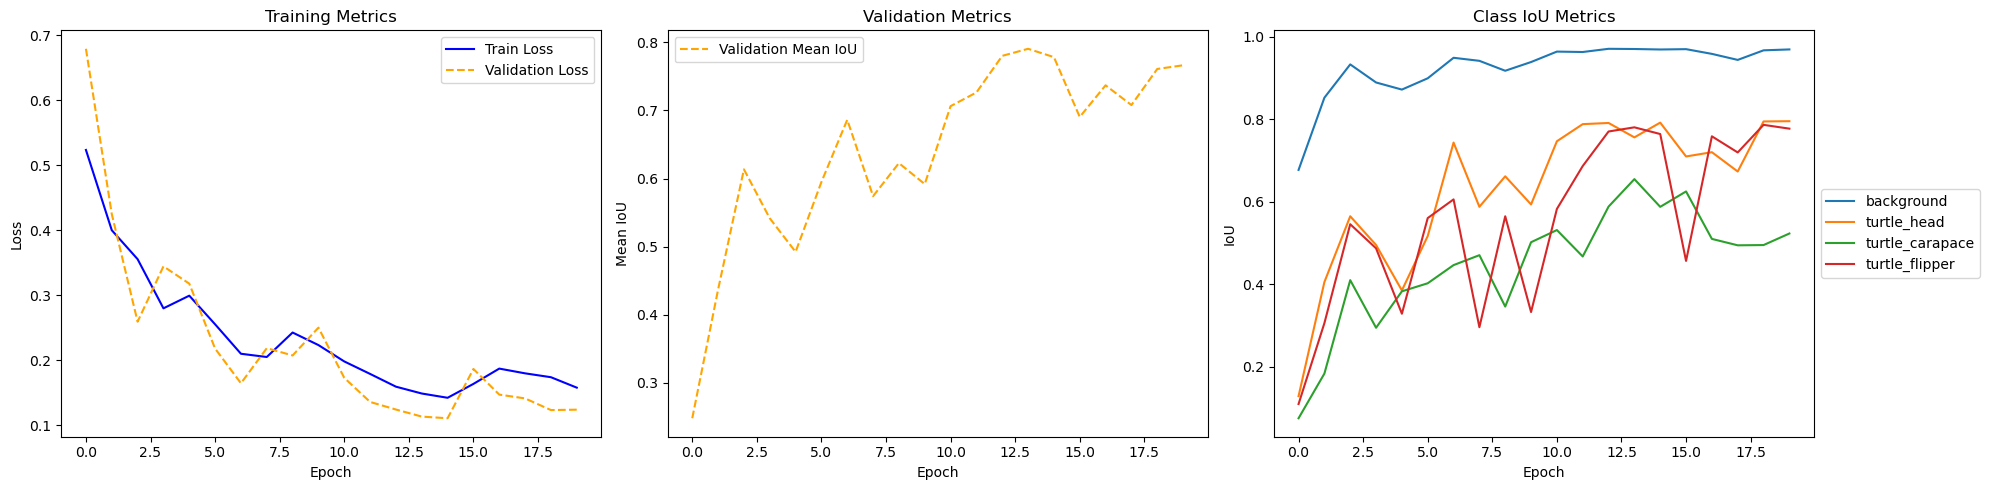


Loading best model for testing...

Evaluating on test set...


C:\Users\cando\AppData\Local\Temp\ipykernel_173016\3723756240.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints/best_model.pth')



Test Results:
Test Mean IoU: 0.8161

Per-class IoU:
background: 0.9800
turtle_head: 0.8382
turtle_carapace: 0.6773
turtle_flipper: 0.7688

Generating final visualizations...

Visualizing test set results...


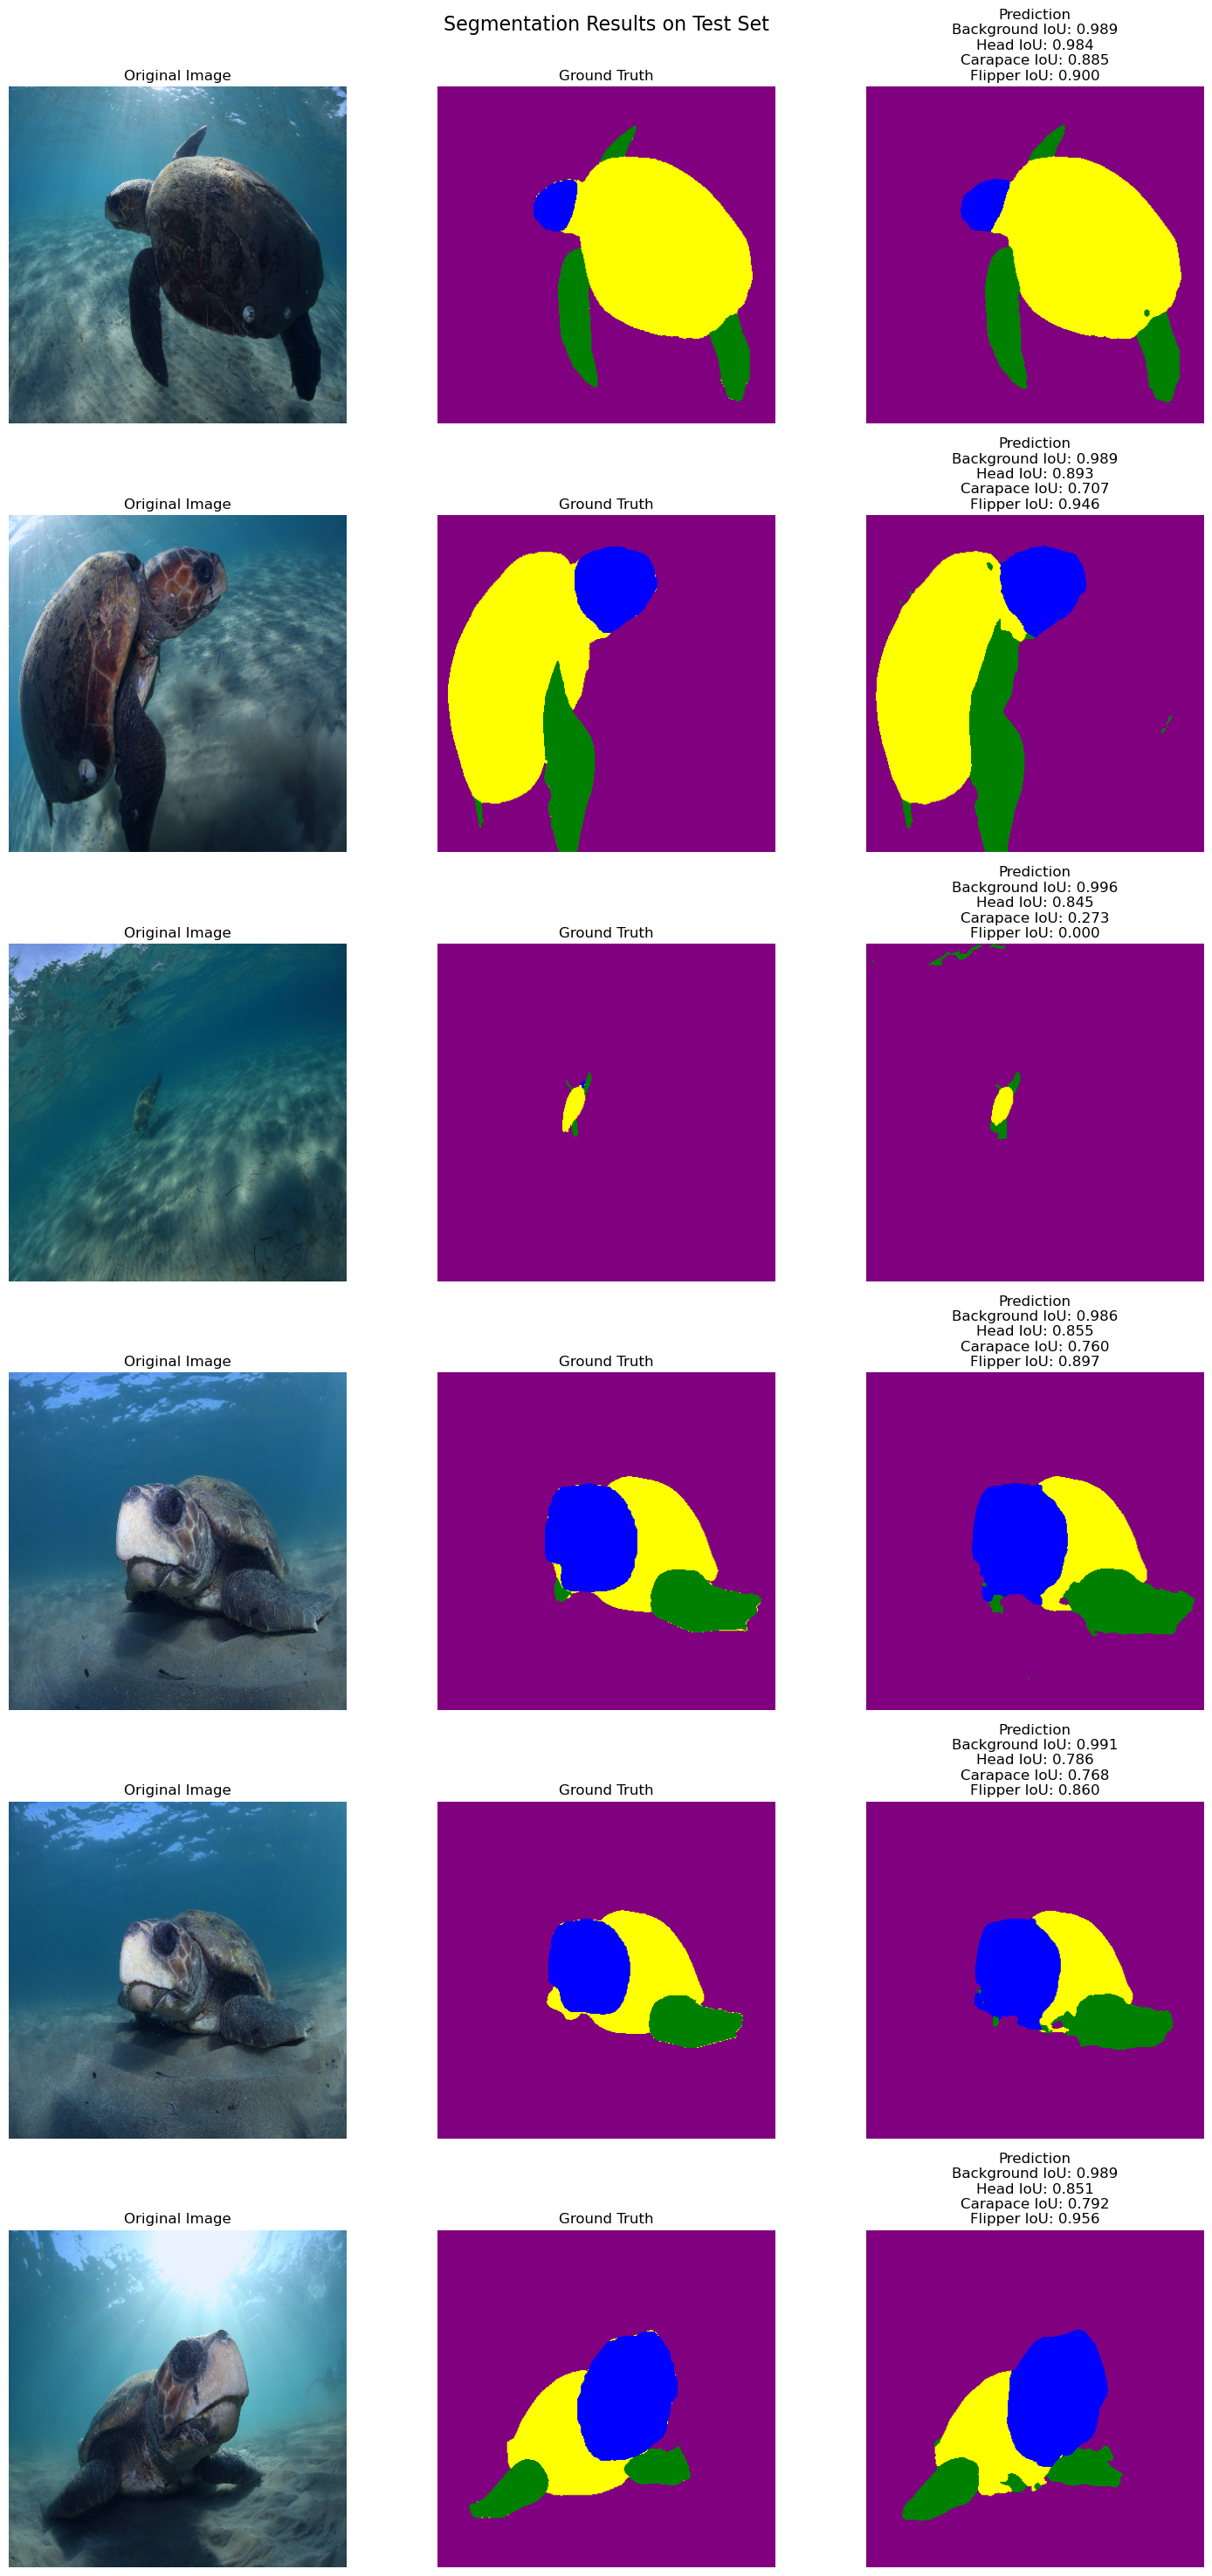


Per-image Segmentation Metrics:
   Background IoU  Head IoU  Carapace IoU  Flipper IoU  Mean IoU
0           0.989     0.984         0.885        0.900     0.940
1           0.989     0.893         0.707        0.946     0.884
2           0.996     0.845         0.273        0.000     0.528
3           0.986     0.855         0.760        0.897     0.874
4           0.991     0.786         0.768        0.860     0.851
5           0.989     0.851         0.792        0.956     0.897

Average Metrics:
Background IoU    0.990
Head IoU          0.869
Carapace IoU      0.697
Flipper IoU       0.760
Mean IoU          0.829
dtype: float64


In [11]:
# Plot training history
print("\nPlotting training history...")
plot_training_history(history)

# Load best model for testing
print("\nLoading best model for testing...")
checkpoint = torch.load('checkpoints/best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Test evaluation
print("\nEvaluating on test set...")
test_metrics = evaluate_model(model, test_loader, criterion, device=device)  # Pass device

print("\nTest Results:")
print(f"Test Mean IoU: {test_metrics['mean_iou']:.4f}")
print("\nPer-class IoU:")
for i in range(NUM_CLASSES):
    print(f"{VOC_CLASSES[i]}: {test_metrics['class_iou'][i]:.4f}")

# Generate final visualizations
print("\nGenerating final visualizations...")
visualize_predictions(
    model,
    test_loader,
    num_samples=6,
    save_path='results/final_predictions.png',
    device=device  # Pass device
)

print("\nVisualizing test set results...")
metrics_df = visualize_sample_predictions(model, test_loader, device=device)  # Pass device


Visualizing the best and the worst in the test set results...


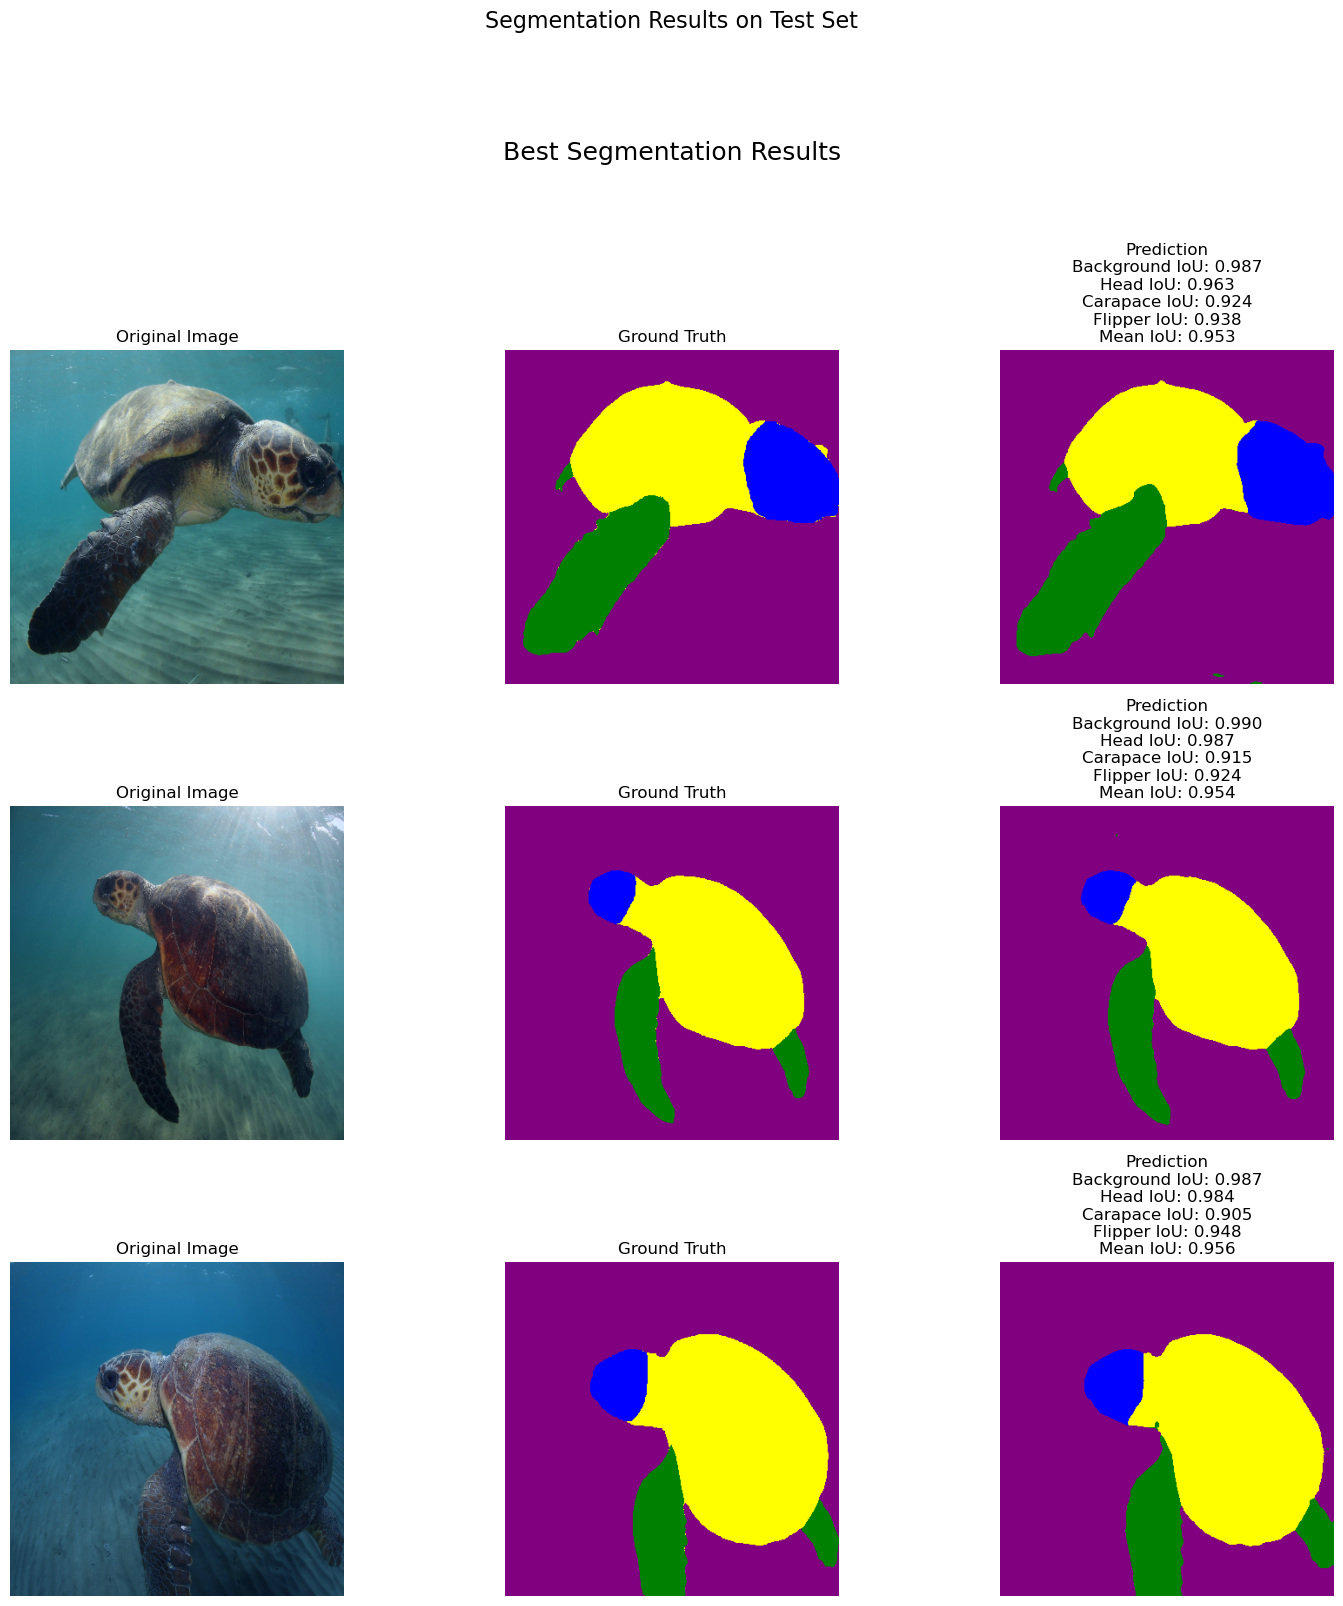

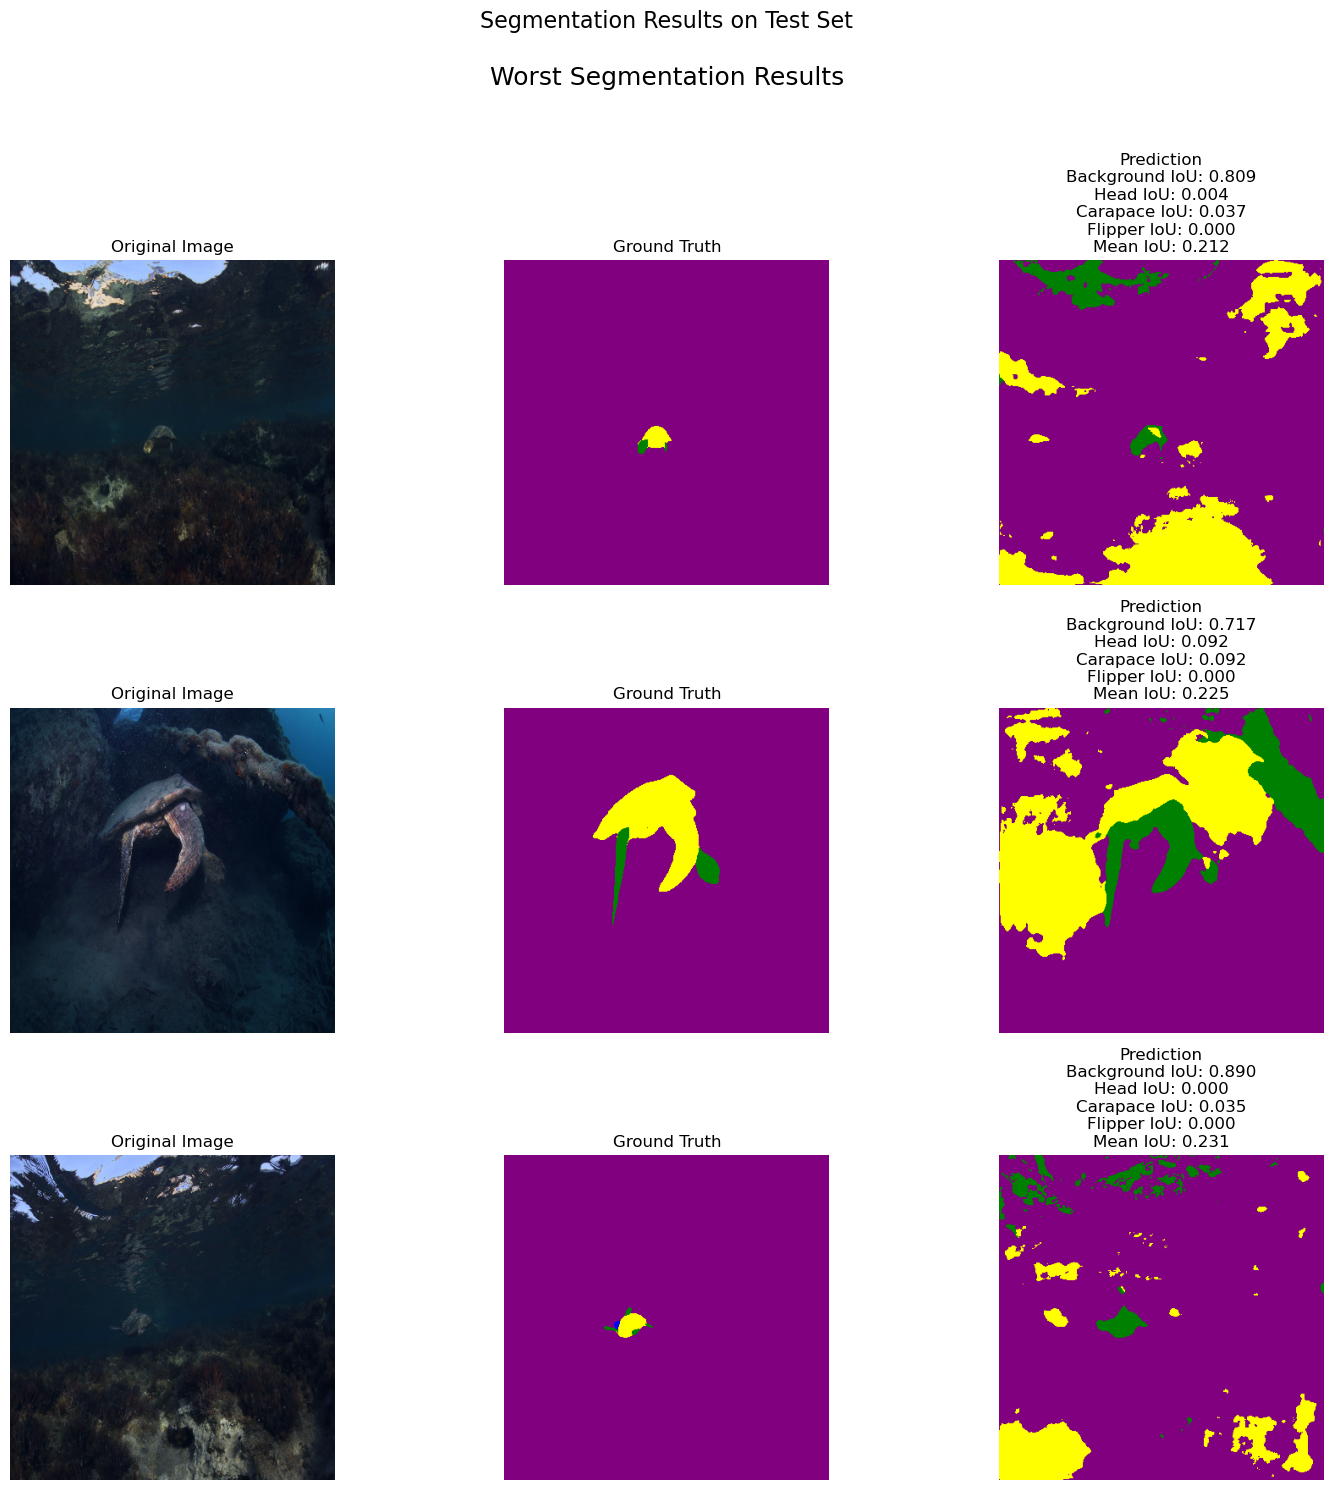


Training and evaluation completed successfully!


In [20]:
print("\nVisualizing the best and the worst in the test set results...")
visualize_best_predictions(model, test_loader, device=device)
visualize_worst_predictions(model, test_loader, device=device)
print("\nTraining and evaluation completed successfully!")